# Reviewing ECMWF hindcasts 

## Check for possibility of a readiness trigger with a longer lead time

The current forecast (Meteo France La Reunion) provides limited lead time and we should explore if we could use ECMWF to have a readiness signal. I would basically check some basic perfomance metrics vs lead time and decide with partners what is acceptable.

In [132]:
%load_ext jupyter_black

import os
from datetime import datetime
from pathlib import Path
import requests
from dateutil import rrule
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import xml.etree.ElementTree as ET

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [59]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
save_dir = (
    Path(AA_DATA_DIR)
    / "public"
    / "exploration"
    / "moz"
    / "ecmwf_hindcast"
)
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date() for dt in gdf_points["ISO_TIME"]
]

In [106]:
gdf_points_moz = gpd.sjoin(gdf_sel, gdf_points, predicate="intersects")

In [107]:
gdf_points_moz_2006 = gdf_points_moz[gdf_points_moz["year"] >= 2006]

### Getting dates for cyclones

In [111]:
min_max_dates = (
    gdf_points[gdf_points["SID"].isin(gdf_points_moz_2006["SID"])]
    .groupby(["SID", "NAME"])["Date"]
    .agg(["min", "max"])
    .reset_index()
)

In [112]:
min_max_dates

,SID,NAME,min,max
0,2007043S11071,FAVIO,2007-02-11,2007-02-23
1,2008062S10064,JOKWE,2008-03-02,2008-03-16
2,2009082S16039,IZILDA,2009-03-22,2009-03-29
3,2012010S24049,DANDO,2012-01-10,2012-01-18
4,2012056S13057,IRINA,2012-02-25,2012-03-12
5,2013046S20042,HARUNA,2013-02-14,2013-02-28
6,2014015S16043,DELIWE,2014-01-14,2014-01-22
7,2014048S16039,GUITO,2014-02-17,2014-02-24
8,2014086S10041,HELLEN,2014-03-26,2014-04-05
9,2015013S18038,CHEDZA,2015-01-13,2015-01-22


### Downloading Hindcasts

In [ ]:
base_url = "https://data.rda.ucar.edu/ds330.3/ecmf/"
times = ["000000", "120000"]
date_lists = []
for index, row in min_max_dates.iterrows():
    min_date = row["min"]
    max_date = row["max"]
    date_list = pd.date_range(start=min_date, end=max_date).tolist()
    for date in date_list:
        date = date.strftime("%Y%m%d")
        year = date[0:4]
        for time in times:
            server = "test"
            if date >= 20080801:
                server = "prod"
            filename = f"z_tigge_c_ecmf_{date}{time}_ifs_glob_{server}_all_glo.xml"
            filename_url = f"{base_url}{year}/{date}/{filename}"
            print("Downloading", filename)
            req = requests.get(filename_url, allow_redirects=True)
            open(Path(save_dir) / "xml" / filename, "wb").write(req.content)

### Processing hindcasts

In [97]:
def xml2csv(filename):
    print(f"{filename}")
    try:
        tree = ET.parse(filename)
    except ET.ParseError:
        print("Error with file, skipping")
        return
    root = tree.getroot()

    prod_center = root.find("header/productionCenter").text
    baseTime = root.find("header/baseTime").text

    # Create one dictonary for each time point, and append it to a list
    for members in root.findall("data"):
        mtype = members.get("type")
        if mtype not in ["forecast", "ensembleForecast"]:
            continue
        for members2 in members.findall("disturbance"):
            cyclone_name = [
                name.text.lower().strip() for name in members2.findall("cycloneName")
            ]
            if not cyclone_name:
                continue
            cyclone_name = cyclone_name[0].lower()
            if cyclone_name not in list(min_max_dates["NAME"].str.lower()):
                continue
            print(f"Found cyclone {cyclone_name}")
            for members3 in members2.findall("fix"):
                tem_dic = {}
                tem_dic["mtype"] = [mtype]
                tem_dic["product"] = [re.sub("\\s+", " ", prod_center).strip().lower()]
                tem_dic["cyc_number"] = [
                    name.text for name in members2.findall("cycloneNumber")
                ]
                tem_dic["ensemble"] = [members.get("member")]
                tem_dic["speed"] = [
                    name.text
                    for name in members3.findall("cycloneData/maximumWind/speed")
                ]
                tem_dic["pressure"] = [
                    name.text
                    for name in members3.findall("cycloneData/minimumPressure/pressure")
                ]
                time = [name.text for name in members3.findall("validTime")]
                tem_dic["time"] = [
                    "/".join(time[0].split("T")[0].split("-"))
                    + ", "
                    + time[0].split("T")[1][:-1]
                ]
                tem_dic["lat"] = [name.text for name in members3.findall("latitude")]
                tem_dic["lon"] = [name.text for name in members3.findall("longitude")]
                tem_dic["lead_time"] = [members3.get("hour")]
                tem_dic["forecast_time"] = [
                    "/".join(baseTime.split("T")[0].split("-"))
                    + ", "
                    + baseTime.split("T")[1][:-1]
                ]
                tem_dic1 = dict(
                    [
                        (k, "".join(str(e).lower().strip() for e in v))
                        for k, v in tem_dic.items()
                    ]
                )
                # Save to CSV
                outfile = save_dir / f"csv/{cyclone_name}_all.csv"
                pd.DataFrame(tem_dic1, index=[0]).to_csv(
                    outfile,
                    mode="a",
                    header=not os.path.exists(outfile),
                    index=False,
                )

In [ ]:
filename_list = sorted(list(Path(save_dir / "xml").glob("*.xml")))
for filename in filename_list:
    xml2csv(filename)

### Getting the location error

RMSE Latitude: 2.42
RMSE Longitude: 4.40


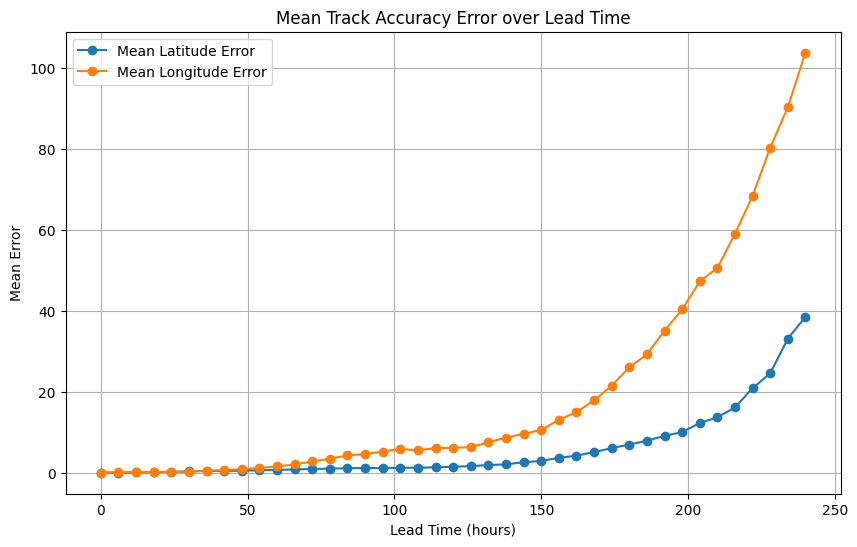

In [142]:
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])
gdf_points_cyclone = gdf_points[gdf_points["NAME"] == "FREDDY"]
cyclone_file = pd.read_csv(save_dir / f"csv/freddy_all.csv")
cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])
df = pd.merge(
    gdf_points_cyclone, cyclone_file, left_on="ISO_TIME", right_on="time", how="inner"
)
# Calculate errors (for simplicity, using mean squared error)
df["latitude_error"] = (df["lat"] - df["LAT"]) ** 2
df["longitude_error"] = (df["lon"] - df["LON"]) ** 2

# Group by lead time and calculate mean error
error_summary = (
    df.groupby("lead_time")
    .agg({"latitude_error": "mean", "longitude_error": "mean"})
    .reset_index()
)

# Calculate RMSE for latitude and longitude
rmse_latitude = np.sqrt(error_summary["latitude_error"].mean())
rmse_longitude = np.sqrt(error_summary["longitude_error"].mean())

print(f"RMSE Latitude: {rmse_latitude:.2f}")
print(f"RMSE Longitude: {rmse_longitude:.2f}")

# Visualize the errors over lead time
plt.figure(figsize=(10, 6))
plt.plot(
    error_summary["lead_time"],
    error_summary["latitude_error"],
    marker="o",
    label="Mean Latitude Error",
)
plt.plot(
    error_summary["lead_time"],
    error_summary["longitude_error"],
    marker="o",
    label="Mean Longitude Error",
)
plt.xlabel("Lead Time (hours)")
plt.ylabel("Mean Error")
plt.title("Mean Track Accuracy Error over Lead Time")
plt.legend()
plt.grid(True)
plt.show()

### Getting the intensity error

RMSE Intensity: 23.10


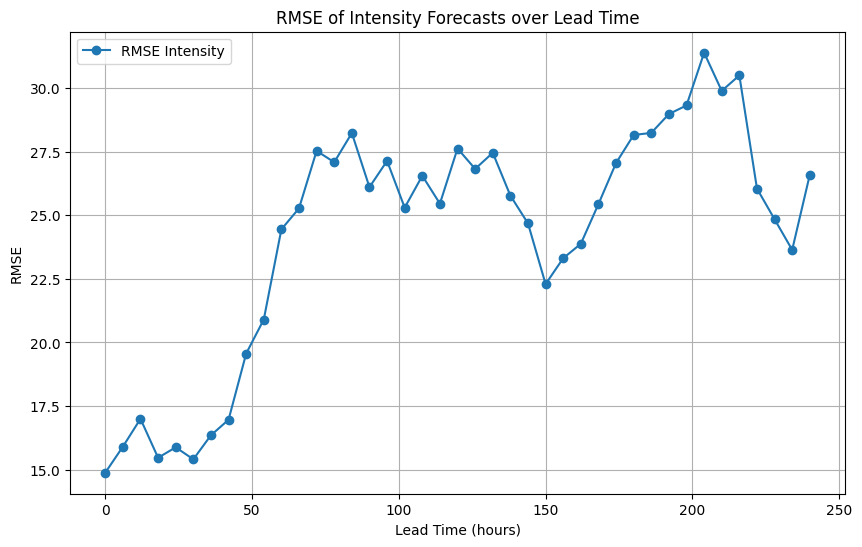

In [143]:
# Calculate intensity error
df["intensity_error"] = ((df["speed"] * 1.94384 * 1.33) - df["USA_WIND"]) ** 2

# Calculate RMSE for intensity
rmse_intensity = np.sqrt(df["intensity_error"].mean())
print(f"RMSE Intensity: {rmse_intensity:.2f}")

# Additional analysis: RMSE over different lead times
error_summary = df.groupby("lead_time")["intensity_error"].mean().reset_index()
error_summary["rmse"] = np.sqrt(error_summary["intensity_error"])

plt.figure(figsize=(10, 6))
plt.plot(
    error_summary["lead_time"],
    error_summary["rmse"],
    marker="o",
    label="RMSE Intensity",
)
plt.xlabel("Lead Time (hours)")
plt.ylabel("RMSE")
plt.title("RMSE of Intensity Forecasts over Lead Time")
plt.legend()
plt.grid(True)
plt.show()